In [1]:
import os
import openai
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv()) 
openai.api_key  = os.getenv('OPENAI_API_KEY')

### Create tools

In [2]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [3]:
from langchain.agents import tool

@tool
def appdef(query: str) -> dict:
    """
    This tool can find out details of application given the application name. 
    Do not try to pass on anything else like container name, secret name etc. 
    Only Application name should be used.
    """
    
    data = {
      "deployment_my-app-deployment": [
        "pod_my-app-deployment-abc123",
        "pod_my-app-deployment-xyz456"
      ],
      "pod_my-app-deployment-abc123": [
        "container_app-container",
        "configmap_my-app-config",
        "secret_my-app-secret",
        "pvc_my-app-pvc"
      ],
      "pod_my-app-deployment-xyz456": [
        "container_app-container",
        "configmap_my-app-config",
        "secret_my-app-secret",
        "pvc_my-app-pvc"
      ],
      "service_my-app-service": [
        "pod_my-app-deployment-abc123",
        "pod_my-app-deployment-xyz456"
      ],
      "ingress_my-app-ingress": [
        "service_my-app-service"
      ]
    }
    return data

In [4]:
#tools = [podhealth]

### Helper Tools

In [5]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

### 

In [6]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    print("***********inside agent_node**********************")
    for key in state:
        print(key," : ",state[key])
    print("*********************************")
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Create Supervisor

In [7]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # This is storing the initial question from the user
    task: str
    # This will store the appname    
    appname: str
    # This stores the composition of the application
    # This should probably be a python dict at some point
    composition: str    
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str
    # The 'summary' field contains the final summary
    summary: str    




In [8]:
SUPERVISOR_PROMPT = """You are a supervisor tasked with getting the application health. \
    You have the following workers:  {members}. Given the user request, \
    find the application name that user is asking about. \
    Use the worker/member that can do it. \
    Once you have got the application name, \
    find out the health of that application from the metrics point of view. \
    Use the worker/member that can do it. \
    Just respond with the worker/member name who should act next - nothing else. \
    Each worker will perform a \
    task and respond with their results and status. \
    Hint - the order in which the members are organized is the order in which they can be called. \
    Concretely - call Appdetect first. After its done, call Appmetric etc. \
    When finished, respond with FINISH."""

In [9]:
APPDETECT_PROMPT = """You are an expert at determining the application name from a query.\
Find out the application name and just return the application name and nothing else. """

In [10]:
APPMETRIC_PROMPT = """You are an expert at determining the application health from the metrics they emit.\
You only need the application name to be passed on as : {appname}. Always return the message - All is healthy """

In [11]:
SUMMARY_PROMPT = """You are an expert at summarizing the state of affairs. \
So summarize the data that is being passed on to you. \
Create a concluding statement - call it in conclusion - a summarize your findings in a binary manner - good or bad. 
------

{content}"""

In [12]:
members = ["Appdetect","Appmetric","Summary"] 

In [13]:
def supervisor_chain(state: AgentState):
    
    
    if isinstance(state['messages'][-1], str):
        msg = state['messages'][-1]
    else:
        msg = state['messages'][-1].content

    messages = [
        SystemMessage(content=SUPERVISOR_PROMPT.format(members=members)), 
        #HumanMessage(content=state['task']
        #HumanMessage(content=state['messages'][-1].content)
        HumanMessage(content=msg)
        
   ]
    #state['task']=state['messages'][0].content
    print("*************inside supervisor_chain********************")
    for key in state:
        print(key," : ",state[key])
    
    #print(messages)
    print("*********************************")
    #get latest of the state[messages] 
    #that is ouput of the last worker
    #print(state['messages'][-1])
    
    
    #model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
    #modelt = model.bind_tools(tools)
    #response = model.invoke(messages)
    
    #if state['appname'] == 'None':
    if not state['appname']:
        value = 'Appdetect'
    elif state['next'] == 'Appdetect':
        value = 'Appmetric'
    elif state['next'] == 'Appmetric':
        value = 'Summary'   
    else:
        value = 'FINISH'
    

    #print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    #print(value)
    return {"next": value,"task":state['messages'][0].content }

In [14]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage


def appdetect_node(state: AgentState):
    print("*************inside appdetect_node********************")
    for key in state:
        print(key," : ",state[key])
        #print(type(state[key]))
    print("*********************************")
    messages = [
        SystemMessage(content=APPDETECT_PROMPT), 
        #HumanMessage(content=state['messages'][0].content)
        HumanMessage(content=state['task'])
    ]
   
    
    

    model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
    response = model.invoke(messages)
    #state['appname']=response.content
    
    print(response)

    return {"messages": [response.content],"appname":response.content }

In [15]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage


def appmetric_node(state: AgentState):
    print("*************inside appmetric_node********************")
    for key in state:
        print(key," : ",state[key])
        #print(type(state[key]))
    print("*********************************")
    appname = state['appname']
    
    messages = [
        SystemMessage(content=APPMETRIC_PROMPT.format(appname = appname)) ,
        #HumanMessage(content=state['messages'][0].content)
        #HumanMessage(content=state['appname'])
   ]

    model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
    response = model.invoke(messages)

    return {"messages": [response.content]}

In [16]:
def summary_node(state: AgentState):
    print("*************inside summary_node********************")
    for key in state:
        print(key," : ",state[key])
        #print(type(state[key]))
    print("*********************************")
    content = state['messages']  
    messages = [
        SystemMessage(content=SUMMARY_PROMPT.format(content=content)),
        #HumanMessage(content=state['action'])
    ]
    
    model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
    response = model.invoke(messages)
    
    return {"summary": response.content}

### Construct Graph

#### Add Nodes

In [17]:
#research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
#research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION

#code_agent = create_agent(
#    llm,
#    [python_repl_tool],
#    "You may generate safe python code to analyze data and generate charts using matplotlib.",
#)
#code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
#workflow.add_node("Researcher", research_node)
#workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)
workflow.add_node("Appdetect",appdetect_node)
workflow.add_node("Appmetric",appmetric_node)
workflow.add_node("Summary",summary_node)

#### Add Edges

In [18]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")


#### Compile Graph

In [19]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver.from_conn_string(":memory:")


#graph = workflow.compile()
graph = workflow.compile(checkpointer=memory)

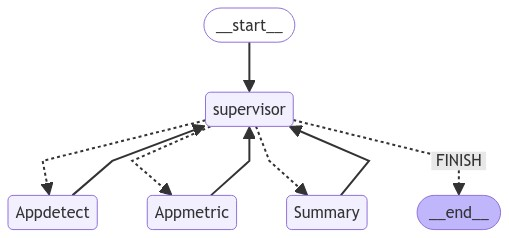

In [20]:
from IPython.display import Image, display
#from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeColors
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

Invoke code

In [21]:
thread = {"configurable": {"thread_id": "1"}}

    
for s in graph.stream(
    {"messages": [HumanMessage(content="How is the health of my application retailbanking.")]},
    #{"task": "How is the health of my application retail_banking."},
    #{"recursion_limit": 4},
    thread
    ):
    if "__end__" not in s:
        print(s)
        print("----")

*************inside supervisor_chain********************
task  :  None
appname  :  None
composition  :  None
messages  :  [HumanMessage(content='How is the health of my application retailbanking.')]
next  :  None
summary  :  None
*********************************
{'supervisor': {'task': 'How is the health of my application retailbanking.', 'next': 'Appdetect'}}
----
*************inside appdetect_node********************
task  :  How is the health of my application retailbanking.
appname  :  None
composition  :  None
messages  :  [HumanMessage(content='How is the health of my application retailbanking.')]
next  :  Appdetect
summary  :  None
*********************************
content='retailbanking' response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 50, 'total_tokens': 54}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-2e6b9ffa-b146-4025-9f1b-a11b264e2084-0' usage_metadata={'input_tokens': 50, 'o